In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import soundfile as sf
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D,
                                     UpSampling2D, BatchNormalization, MaxPooling2D, Conv2DTranspose)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [2]:

def get_prior(num_modes, latent_dim):
    """
    This function should create an instance of a MixtureSameFamily distribution
    according to the above specification.
    The function takes the num_modes and latent_dim as arguments, which should
    be used to define the distribution.
    Your function should then return the distribution instance.
    """
    gm = tfp.distributions.MixtureSameFamily(
        # the mixture_distribution should be fixed to a uniform
        # tfd.Categorical distribution, so that  pik=1/K  in the above equation.
        # This argument will therefore not contain any trainable variables
        mixture_distribution=tfp.distributions.Categorical(
            probs=[1.0/num_modes,]*num_modes),

        # The components_distribution should be a tfd.MultivariateNormalDiag
        # distribution batch shape equal to [num_modes] and event shape equal to [latent_dim].
        components_distribution = tfp.distributions.MultivariateNormalDiag(
          # should have trainable loc parameter (initialised with a random normal distribution)
          loc = tf.Variable(tf.random.normal(shape = [num_modes, latent_dim])),

          # and trainable scale_diag parameter (initialised to ones)
          # The scale_diag variable should be enforced to be positive using
          # tfp.util.TransformedVariable and the tfb.Softplus bijection
          scale_diag = tfp.util.TransformedVariable(
                                                tf.Variable(
                                                  tf.ones(shape = [num_modes, latent_dim])),
                                                bijector = tfp.bijectors.Softplus()
                                                )
        )
      )


    return gm


In [3]:
# Run your function to get the prior distribution with 2 components and latent_dim = 50

prior = get_prior(num_modes=2, latent_dim=100)

In [4]:
def get_kl_regularizer(prior_distribution):
    """
    This function should create an instance of the KLDivergenceRegularizer
    according to the above specification.
    The function takes the prior_distribution, which should be used to define
    the distribution.
    Your function should then return the KLDivergenceRegularizer instance.
    """
    reg = tfp.layers.KLDivergenceRegularizer(
        prior_distribution,
        weight = 1.0,
        use_exact_kl = False,
        test_points_fn = lambda q : q.sample(3),
        test_points_reduce_axis = (0,1))

    return reg

In [5]:
kl_regularizer = get_kl_regularizer(prior)

In [6]:

def get_encoder(latent_dim, kl_regularizer):
    """
    This function should build a CNN encoder model according to the above specification.
    The function takes latent_dim and kl_regularizer as arguments, which should be
    used to define the model.
    Your function should return the encoder model.
    """
    input_shape = (1024,2048,1)
    encoder = Sequential([
        Conv2D(filters = 32, kernel_size = 4, activation = 'relu',
               strides = (2,4), padding = 'SAME', input_shape = input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 4), strides=(2, 4), padding='SAME'), 
        
        Conv2D(filters = 64, kernel_size = 4, activation = 'relu',
               strides = (2,4), padding = 'SAME'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 4), strides=(2, 4), padding='SAME'),  
        
        Conv2D(filters = 128, kernel_size = 4, activation = 'relu',
               strides = (2,4), padding = 'SAME'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 4), strides=(2, 4), padding='SAME'),  

        Conv2D(filters = 256, kernel_size = 4, activation = 'relu',
               strides = (2,4), padding = 'SAME'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 4), strides=(2, 4), padding='SAME'),  

        Flatten(),
        Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim)),
        tfp.layers.MultivariateNormalTriL(latent_dim, activity_regularizer = kl_regularizer)
    ])

    return encoder


In [7]:
encoder = get_encoder(latent_dim=100, kl_regularizer=kl_regularizer)

In [8]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      544       
                                                                 
 batch_normalization (Batch  (None, 512, 512, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 32, 64)       32832     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 32, 64)       256       
 chNormalization)                                                
                                                        

In [9]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(1024, activation='relu', input_shape=(latent_dim,)),
        Reshape((4, 1, 256)),
        Conv2DTranspose(256, kernel_size=3, strides=(2, 4), padding='SAME', activation='relu'),
        BatchNormalization(),
        
        Conv2DTranspose(128, kernel_size=3, strides=(2, 4), padding='SAME', activation='relu'),
        BatchNormalization(),

        Conv2DTranspose(64, kernel_size=3, strides=(4, 4), padding='SAME', activation='relu'),
        BatchNormalization(),

        Conv2DTranspose(32, kernel_size=3, strides=(4, 4), padding='SAME', activation='relu'),
        BatchNormalization(),

        Conv2DTranspose(1, kernel_size=3, strides=(4, 8), padding='SAME', activation='sigmoid'),
        Flatten(),
        tfp.layers.IndependentBernoulli(event_shape = (1024,2048,1))
    ])

    return decoder

In [10]:
decoder = get_decoder(latent_dim=100)

In [11]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1024)              103424    
                                                                 
 reshape (Reshape)           (None, 4, 1, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 4, 256)         590080    
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 8, 4, 256)         1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       295040    
 Transpose)                                                      
                                                      

In [12]:

def reconstruction_loss(batch_of_images, decoding_dist):
    """
    This function should compute and return the average expected reconstruction loss,
    as defined above.
    The function takes batch_of_spectograms (Tensor containing a batch of input spectogram data) and decoding_dist (output distribution of decoder after passing the
    spectogram batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_sum(decoding_dist.log_prob(batch_of_images), axis = 0)

In [13]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [14]:
data = np.load('stft_spectrograms.npz')
loaded_spectrograms_2 = np.array([data[f'{i}'] for i in range(len(data))])

In [15]:
train_data = loaded_spectrograms_2[:1100]
val_data = loaded_spectrograms_2[1100:]
print(len(train_data))

1100


In [16]:
checkpoint_cb = ModelCheckpoint(
    'best_model.keras', 
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

def data_generator(data, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            x_batch = data[i:i+batch_size]
            yield x_batch, x_batch  

train_gen = data_generator(train_data, batch_size=16)
val_gen = data_generator(val_data, batch_size=16)

train_steps = len(train_data) // 16
val_steps = len(val_data) // 16

history = vae.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=150,
    callbacks=[checkpoint_cb]
)

Epoch 1/150

68/68 [==============================] - ETA: 0s - loss: 28817364.0000

C:\Users\mayal\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: MultivariateNormalTriL.new(t, event_size, validate_args),

  config_arr = [serialize_keras_object(x) for x in obj]
C:\Users\mayal\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\serialization_lib.py:159: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: IndependentBernoulli.new(  # pylint: disable=g-

68/68 [==============================] - 162s 2s/step - loss: 28817364.0000 - val_loss: 29240886.0000
Epoch 2/150
68/68 [==============================] - 164s 2s/step - loss: 28252122.0000 - val_loss: 28637584.0000
Epoch 3/150
68/68 [==============================] - 174s 3s/step - loss: 27797882.0000 - val_loss: 28064716.0000
Epoch 4/150
68/68 [==============================] - 173s 3s/step - loss: 27510516.0000 - val_loss: 27780930.0000
Epoch 5/150
68/68 [==============================] - 826s 12s/step - loss: 27318512.0000 - val_loss: 27610960.0000
Epoch 6/150
68/68 [==============================] - 166s 2s/step - loss: 27159356.0000 - val_loss: 27477736.0000
Epoch 7/150
68/68 [==============================] - 166s 2s/step - loss: 27040408.0000 - val_loss: 27318426.0000
Epoch 8/150
68/68 [==============================] - 169s 2s/step - loss: 26917712.0000 - val_loss: 27220024.0000
Epoch 9/150
68/68 [==============================] - 160s 2s/step - loss: 26802932.0000 - val_loss:

68/68 [==============================] - 166s 2s/step - loss: 24074438.0000 - val_loss: 24222456.0000
Epoch 73/150
68/68 [==============================] - 163s 2s/step - loss: 24054352.0000 - val_loss: 24201822.0000
Epoch 74/150
68/68 [==============================] - 160s 2s/step - loss: 24035572.0000 - val_loss: 24181570.0000
Epoch 75/150
68/68 [==============================] - 161s 2s/step - loss: 24014930.0000 - val_loss: 24161704.0000
Epoch 76/150
68/68 [==============================] - 159s 2s/step - loss: 23999564.0000 - val_loss: 24142326.0000
Epoch 77/150
68/68 [==============================] - 161s 2s/step - loss: 23981552.0000 - val_loss: 24123528.0000
Epoch 78/150
68/68 [==============================] - 159s 2s/step - loss: 23962098.0000 - val_loss: 24105070.0000
Epoch 79/150
68/68 [==============================] - 161s 2s/step - loss: 23944506.0000 - val_loss: 24086940.0000
Epoch 80/150
68/68 [==============================] - 157s 2s/step - loss: 23929558.0000 - va

Epoch 143/150
68/68 [==============================] - 155s 2s/step - loss: 23378702.0000 - val_loss: 23464002.0000
Epoch 144/150
68/68 [==============================] - 168s 2s/step - loss: 23374050.0000 - val_loss: 23459704.0000
Epoch 145/150
68/68 [==============================] - 172s 3s/step - loss: 23370736.0000 - val_loss: 23455370.0000
Epoch 146/150
68/68 [==============================] - 157s 2s/step - loss: 23366596.0000 - val_loss: 23451190.0000
Epoch 147/150
68/68 [==============================] - 162s 2s/step - loss: 23362108.0000 - val_loss: 23446876.0000
Epoch 148/150
68/68 [==============================] - 157s 2s/step - loss: 23358196.0000 - val_loss: 23442890.0000
Epoch 149/150
68/68 [==============================] - 159s 2s/step - loss: 23354966.0000 - val_loss: 23439004.0000
Epoch 150/150
68/68 [==============================] - 160s 2s/step - loss: 23351316.0000 - val_loss: 23435212.0000


In [35]:
def generate_music(prior, decoder, n_samples):
    """
    This function should compute generate new samples of spectograms/music from the generative model,
    according to the above instructions.
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the spectogram's data.
    The function should then return the batch of generated spectogram data.
    """
    z = prior.sample(n_samples)
    return decoder(z).mean()

n_samples = 1
sm = generate_music(prior, decoder, n_samples)
print(sm[0])

tf.Tensor(
[[[0.50000006]
  [0.50000006]
  [0.50000006]
  ...
  [0.505936  ]
  [0.505936  ]
  [0.505936  ]]

 [[0.50000024]
  [0.5000002 ]
  [0.5000003 ]
  ...
  [0.505936  ]
  [0.505936  ]
  [0.505936  ]]

 [[0.50000316]
  [0.50000346]
  [0.5000028 ]
  ...
  [0.505936  ]
  [0.505936  ]
  [0.505936  ]]

 ...

 [[0.50000185]
  [0.5000017 ]
  [0.5000017 ]
  ...
  [0.505936  ]
  [0.505936  ]
  [0.505936  ]]

 [[0.50000167]
  [0.50000167]
  [0.500002  ]
  ...
  [0.505936  ]
  [0.505936  ]
  [0.505936  ]]

 [[0.505936  ]
  [0.505936  ]
  [0.505936  ]
  ...
  [0.505936  ]
  [0.505936  ]
  [0.505936  ]]], shape=(1024, 2048, 1), dtype=float32)


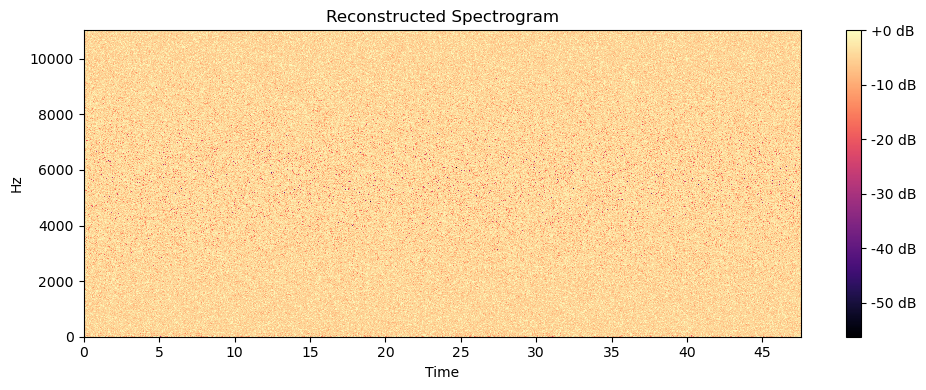

In [29]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

FIXED_MIN_VAL = -80  
FIXED_MAX_VAL = 0 

def inverse_normalize_spectrogram(normalized_spectrogram):
    return normalized_spectrogram * (FIXED_MAX_VAL - FIXED_MIN_VAL) + FIXED_MIN_VAL

def stft_to_audio(tensor, output_path, sr=22050, hop_length=512):
    # Convert tensor to numpy array if it's a TensorFlow tensor
    tensor_np = tensor.numpy() if isinstance(tensor, tf.Tensor) else tensor
    
    # Assuming tensor_np is the magnitude of the STFT
    # Inverse normalization is applied to the magnitude
    tensor_np = inverse_normalize_spectrogram(tensor_np[:, :, 0])
    
    # Use Griffin-Lim algorithm to estimate phase and reconstruct the time-domain signal
    y_reconstructed = librosa.griffinlim(tensor_np, hop_length=hop_length)
    
    # Save the reconstructed audio
    sf.write(output_path, y_reconstructed, sr)
    
    # Optionally, display the spectrogram
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_reconstructed)), ref=np.max)
    librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Reconstructed Spectrogram')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming 'sm[0]' is a predefined spectrogram tensor
stft_to_audio(sm[0], 'new.wav')
